# ****Importing Models****

In [1]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import AutoTokenizer,AutoModelForSequenceClassification
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D,LSTM,Embedding,Conv1D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ****Training data review****

In [3]:
train_data=pd.read_csv('/kaggle/input/anyas-gojo-revival-space-shop/train.tsv', sep='\t')
train_data.head()

,date,time,id,reviewer name,reviewer address,contact number,variation,verified_reviews,sentiment,feedback
0,30-Jul-18,02:16:00,5138527,Theresa Diaz,"2373 Long Mews\nSouth Lorraine, FL 83715",7445448464,Black Plus,Love my new Echo Plus,5,1
1,30-Jul-18,20:13:24,7881409,Michael Wagner,"34120 James Well Apt. 930\nSouth Kenneth, AK 5...",(202)233-6662,Configuration: Fire TV Stick,Works really well.,5,1
2,29-Jul-18,03:20:48,5658396,Erin Rodriguez,"7996 Booth Mission\nTaylorport, AL 13457",(219)882-0705,Black Show,Echo Show is said to work with certain apps bu...,2,0
3,30-Jul-18,22:48:21,4317957,Christine Perez,USS Schaefer\nFPO AA 86432,291-900-6087,Heather Gray Fabric,Very cool product. Speaker sounds good with my...,5,1
4,23-Jul-18,12:36:42,7570569,Jamie Davila,"000 Kevin Cliffs Suite 674\nBrennanview, NM 77690",9527296610,Black Plus,So far I love it. It was easy to set up - if ...,5,1


In [4]:
train_data.isnull().sum()

date                0
time                0
id                  0
reviewer name       0
reviewer address    0
contact number      0
variation           0
verified_reviews    1
sentiment           0
feedback            0
dtype: int64

In [5]:
train_data.fillna({"verified_reviews":"no review"}, inplace=True)

# ****Downloading RoBERTa transformer model****

In [6]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# ****Training Data preprocessing and feature engineering****

**Here we will make new dataframe where columns will be probability of each positive negative and neutral and their combined root mean square also binary representation of each of positive negative and neutral.After that One hot encoded labels will be added for each in "variation" column of train data**

In [7]:
from scipy.special import softmax
pov_review=[]
neg_review=[]
neu_review=[]
com_review=[]
vader_ratings=[]
pov_ratings=[]
neu_ratings=[]
neg_ratings=[]
sid_obj = SentimentIntensityAnalyzer()
for i in train_data['verified_reviews']:
    try:
        encoded_text = tokenizer(i, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        neg_review.append(scores[0])
        neu_review.append(scores[1])
        pov_review.append(scores[2])
        com_review.append((scores[0]**2+scores[1]**2+scores[2]**2)**(0.5))
        sentiment_dict = sid_obj.polarity_scores(i)
        vader_ratings.append(sentiment_dict['compound'])
        if max(scores)==scores[0]:
            neg_ratings.append(1.0)
            neu_ratings.append(0.0)
            pov_ratings.append(0.0)
        elif max(scores)==scores[1]:
            neg_ratings.append(0.0)
            neu_ratings.append(1.0)
            pov_ratings.append(0.0)
        elif max(scores)==scores[2]:
            neg_ratings.append(0.0)
            neu_ratings.append(0.0)
            pov_ratings.append(1.0)
    except RuntimeError:
        print(1)
        pov_review.append(0.0)
        neg_review.append(0.0)
        neu_review.append(1.0)
        com_review.append(1.0)
        vader_ratings.append(1.0)
        neg_ratings.append(0.0)
        neu_ratings.append(1.0)
        pov_ratings.append(.0)

1
1


In [8]:
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(train_data[['variation']])
one_hot_df = pd.DataFrame(one_hot_encoded.toarray(), columns=encoder.get_feature_names_out(['variation']))
one_hot_df.head()

,variation_Black,variation_Black Dot,variation_Black Plus,variation_Black Show,variation_Black Spot,variation_Charcoal Fabric,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
new_dataframe=pd.DataFrame({"positive":pov_review,"negative":neg_review,"neutral":neu_review,"combined":com_review,"feedback":list(map(lambda x: float(x),train_data['feedback'])),"isPositive":pov_ratings,"isNegative":neg_ratings,"isNeutral":neu_ratings ,"vader":vader_ratings})
new_dataframe = pd.concat([new_dataframe, one_hot_df], axis=1)
new_dataframe.pop("combined")
new_dataframe.head()

,positive,negative,neutral,feedback,isPositive,isNegative,isNeutral,vader,variation_Black,variation_Black Dot,...,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.989508,0.001466,0.009026,1.0,1.0,0.0,0.0,0.6369,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.936137,0.004737,0.059127,1.0,1.0,0.0,0.0,0.3384,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.107922,0.570545,0.321533,0.0,0.0,1.0,0.0,0.9654,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.988388,0.001345,0.010267,1.0,1.0,0.0,0.0,0.6697,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.991431,0.002093,0.006476,1.0,1.0,0.0,0.0,0.9549,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
new_dataframe.head()

,positive,negative,neutral,feedback,isPositive,isNegative,isNeutral,vader,variation_Black,variation_Black Dot,...,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.989508,0.001466,0.009026,1.0,1.0,0.0,0.0,0.6369,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.936137,0.004737,0.059127,1.0,1.0,0.0,0.0,0.3384,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.107922,0.570545,0.321533,0.0,0.0,1.0,0.0,0.9654,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.988388,0.001345,0.010267,1.0,1.0,0.0,0.0,0.6697,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.991431,0.002093,0.006476,1.0,1.0,0.0,0.0,0.9549,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ****Data Visualization****

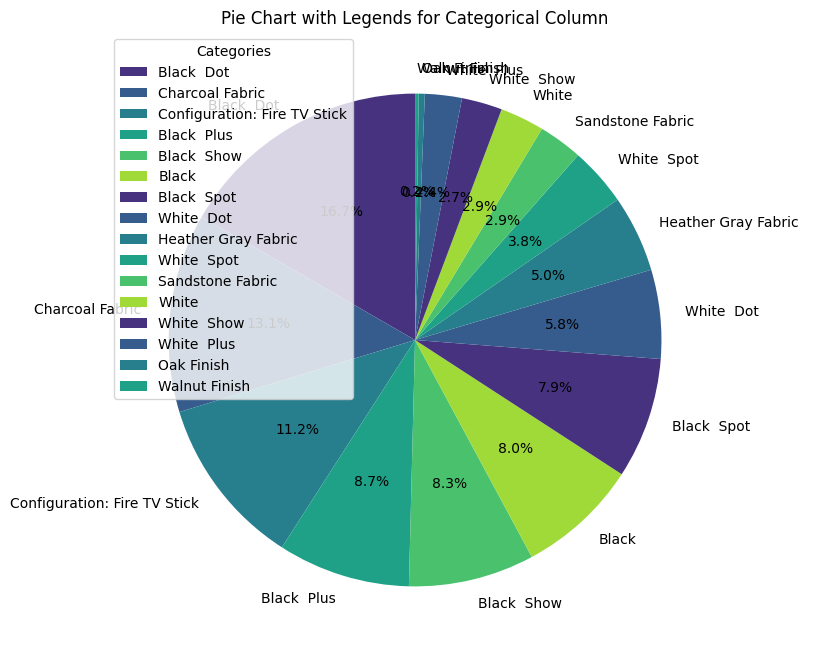

In [11]:
plt.figure(figsize=(8, 8))
plt.pie(train_data['variation'].value_counts().values, labels=train_data['variation'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Pie Chart with Legends for Categorical Column')
plt.legend(title='Categories', labels=train_data['variation'].value_counts().index, loc='best')
plt.show()

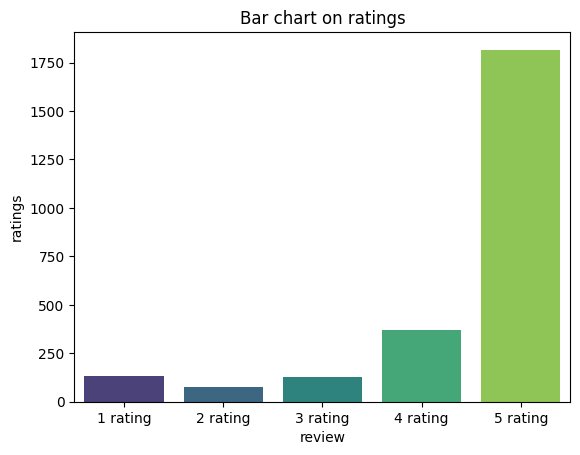

In [12]:
sns.barplot(x=["1 rating","2 rating","3 rating","4 rating","5 rating"],y=[sum([1 for i in train_data['sentiment'] if i==1.0]),sum([1 for i in train_data['sentiment'] if i==2.0]),sum([1 for i in train_data['sentiment'] if i==3.0]),sum([1 for i in train_data['sentiment'] if i==4.0]),sum([1 for i in train_data['sentiment'] if i==5.0])], palette="viridis")
plt.xlabel('review')
plt.ylabel('ratings')
plt.title('Bar chart on ratings')
plt.show()

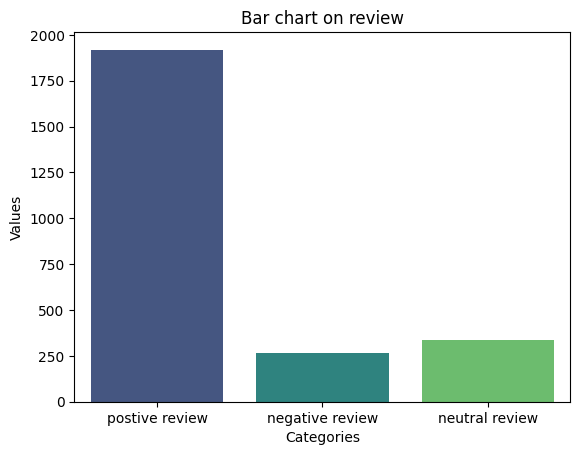

In [13]:
sns.barplot(x=["postive review","negative review","neutral review"],y=[sum(pov_ratings),sum(neg_ratings),sum(neu_ratings)], palette="viridis")
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar chart on review')
plt.show()

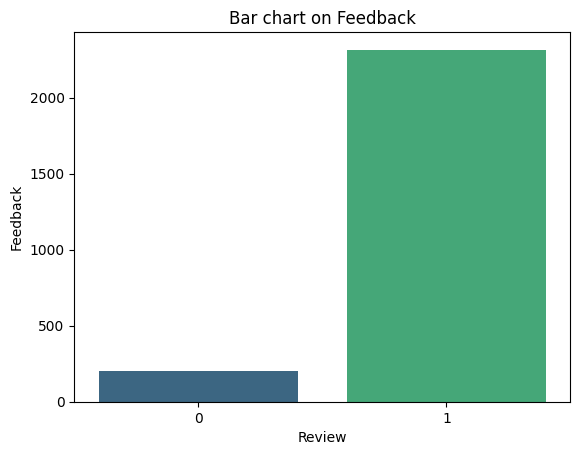

In [14]:
sns.barplot(x=["0","1"],y=[sum([1 for i in train_data['feedback'] if i==0.0]),sum([1 for i in train_data['feedback'] if i==1.0])], palette="viridis")
plt.xlabel('Review')
plt.ylabel('Feedback')
plt.title('Bar chart on Feedback')
plt.show()

# ****Training RandomForestClassifier on data featured out****

In [15]:
from sklearn import preprocessing
new_dataframe = preprocessing.StandardScaler().fit(new_dataframe).transform(new_dataframe.astype(float))
X_train, X_test, y_train, y_test = train_test_split(new_dataframe, train_data['sentiment'],  test_size=0.1, random_state=42) 
dtree_model = RandomForestClassifier(n_estimators=200 ,random_state=16,).fit(X_train, y_train)
dtree_predictions = dtree_model.score(X_test,y_test)
print(dtree_predictions)

0.8214285714285714


# ****Model Analysis****

0.6704472991796935


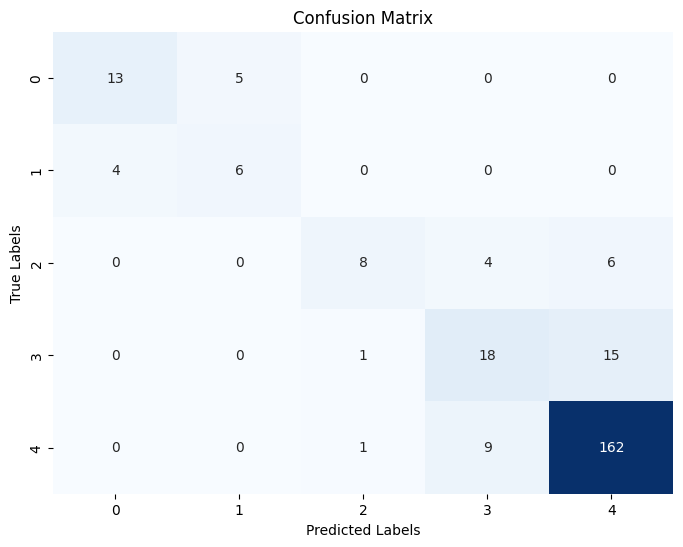

In [16]:
y_pred = dtree_model.predict(X_test)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(macro_f1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ****Testing Data preprocessing and feature engineering****

In [17]:
test_data=pd.read_csv('/kaggle/input/anyas-gojo-revival-space-shop/test.tsv', sep='\t')
pov_test_review=[]
neg_test_review=[]
neu_test_review=[]
com_test_review=[]
neg_test_ratings=[]
neu_test_ratings=[]
pov_test_ratings=[]
vader_test_ratings=[]
for i in test_data['verified_reviews']:
    try:
        encoded_text = tokenizer(i, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        neg_test_review.append(scores[0])
        neu_test_review.append(scores[1])
        pov_test_review.append(scores[2])
        com_test_review.append((scores[0]**2+scores[1]**2+scores[2]**2)**(0.5))
        sentiment_dict = sid_obj.polarity_scores(i)
        vader_test_ratings.append(sentiment_dict['compound'])
        if max(scores)==scores[0]:
            neg_test_ratings.append(1.0)
            neu_test_ratings.append(0.0)
            pov_test_ratings.append(0.0)
        elif max(scores)==scores[1]:
            neg_test_ratings.append(0.0)
            neu_test_ratings.append(1.0)
            pov_test_ratings.append(0.0)
        elif max(scores)==scores[2]:
            neg_test_ratings.append(0.0)
            neu_test_ratings.append(0.0)
            pov_test_ratings.append(1.0)
    except RuntimeError:
        print(1)
        pov_test_review.append(1.0)
        neg_test_review.append(0.0)
        neu_test_review.append(0.0)
        com_test_review.append(1.0)
        neg_test_ratings.append(0.0)
        neu_test_ratings.append(0.0)
        pov_test_ratings.append(1.0)

In [18]:
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(test_data[['variation']])
one_hot_df = pd.DataFrame(one_hot_encoded.toarray(), columns=encoder.get_feature_names_out(['variation']))
one_hot_df.head()

,variation_Black,variation_Black Dot,variation_Black Plus,variation_Black Show,variation_Black Spot,variation_Charcoal Fabric,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
test_dataframe=pd.DataFrame({"positive":pov_test_review,"negative":neg_test_review,"neutral":neu_test_review,"combined":com_test_review,"feedback":list(map(lambda x: float(x),test_data['feedback'])),"isPositive":pov_test_ratings,"isNegative":neg_test_ratings,"isNeutral":neu_test_ratings,"vader":vader_test_ratings})
test_dataframe = pd.concat([test_dataframe, one_hot_df], axis=1)
test_dataframe.pop("combined")
test_dataframe.head()

,positive,negative,neutral,feedback,isPositive,isNegative,isNeutral,vader,variation_Black,variation_Black Dot,...,variation_Configuration: Fire TV Stick,variation_Heather Gray Fabric,variation_Oak Finish,variation_Sandstone Fabric,variation_Walnut Finish,variation_White,variation_White Dot,variation_White Plus,variation_White Show,variation_White Spot
0,0.984899,0.002404,0.012697,1.0,1.0,0.0,0.0,0.9802,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.986175,0.003311,0.010514,1.0,1.0,0.0,0.0,0.8519,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.005175,0.963042,0.031783,0.0,0.0,1.0,0.0,-0.7507,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.858581,0.032428,0.108991,1.0,1.0,0.0,0.0,0.9741,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.963731,0.003297,0.032972,1.0,1.0,0.0,0.0,0.6705,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ****Running Model on test data**** 

In [20]:
arr=dtree_model.predict(test_dataframe)
print(arr)

[4 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 5 4 5 5 5 5 5 4 4 5 5 5 4 4 4
 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 4 4 5 4 5 4 5 4 5 4 4 4
 4 5 5 5 4 5 5 4 4 4 4 5 5 5 5 5 4 5 5 5 5 4 5 4 5 5 5 5 5 5 5 5 5 5 5 5 4
 5 5 5 4 4 5 5 5 4 4 5 4 5 4 5 4 4 5 4 5 4 5 5 5 5 4 5 4 5 5 5 5 4 5 5 4 5
 4 5 4 5 4 5 5 4 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 4 5 5 5 5 5 5 5 5 4 5 5
 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 4 4 5 4 5 5 4 5 5 4 4 5 5 5 5 5 5 5
 5 4 5 5 5 5 5 4 5 5 5 4 5 4 4 5 5 5 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 4 4 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 4 5 4 5 5 5 5 5 5 4 4 4 5 5
 5 4 4 5 5 5 5 5 5 4 4 5 5 4 5 5 5 4 4 5 5 5 5 5 5 5 5 4 5 4 4 4 5 4 4 5 5
 5 4 5 5 5 5 5 5 5 4 5 5 5 4 4 4 5 4 5 5 4 5 5 4 4 5 5 4 5 4 5 5 4 5 5 5 5
 5 5 5 4 5 5 5 5 5 5 5 4 5 5 5 4 4 5 5 5 4 4 5 5 4 5 5 5 5 4 5 5 5 4 4 5 5
 4 4 4 5 5 4 5 5 5 4 4 5 5 4 5 4 4 5 4 5 5 5 4 5 4 4 5 4 4 4 4 5 5 5 5 5 5
 5 4 4 5 5 5 4 5 5 5 5 5 5 5 4 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 4 5 5 4 4
 5 5 5 4 5 5 5 5 5 4 4 4 

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# ****Test data and Result Visualization****

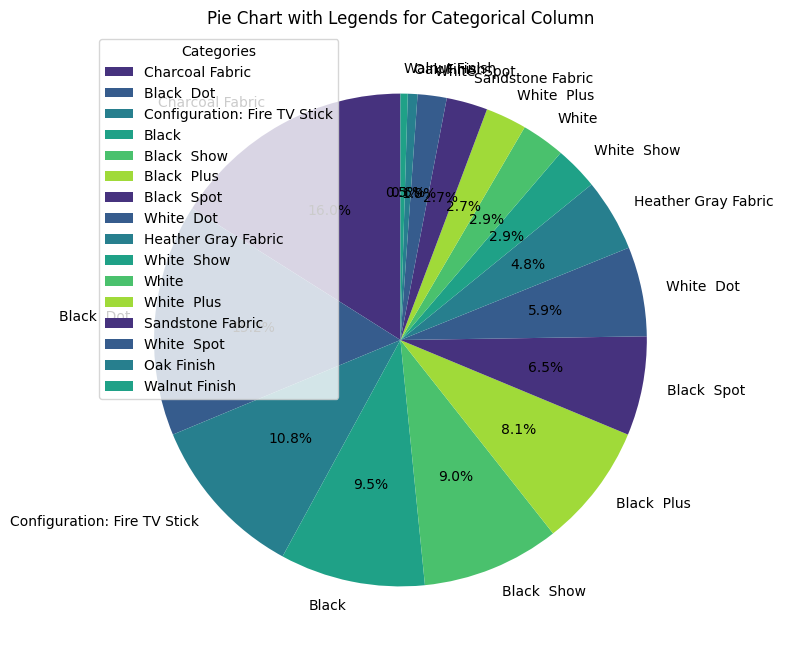

In [21]:
plt.figure(figsize=(8, 8))
plt.pie(test_data['variation'].value_counts().values, labels=test_data['variation'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Pie Chart with Legends for Categorical Column')
plt.legend(title='Categories', labels=test_data['variation'].value_counts().index, loc='best')
plt.show()

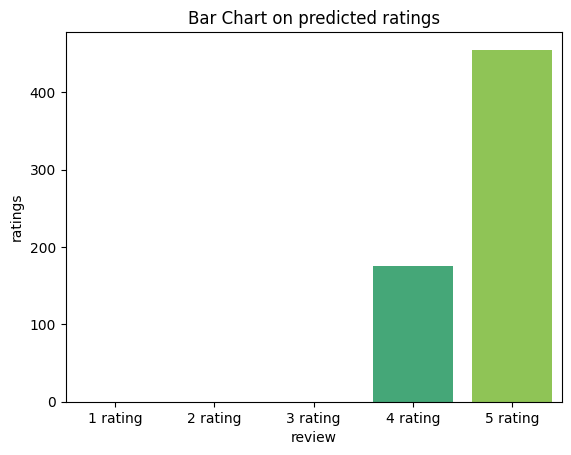

In [22]:
sns.barplot(x=["1 rating","2 rating","3 rating","4 rating","5 rating"],y=[sum([1 for i in arr if i==1]),sum([1 for i in arr if i==2]),sum([1 for i in arr if i==3]),sum([1 for i in arr if i==4]),sum([1 for i in arr if i==5])], palette="viridis")
plt.xlabel('review')
plt.ylabel('ratings')
plt.title('Bar Chart on predicted ratings')
plt.show()

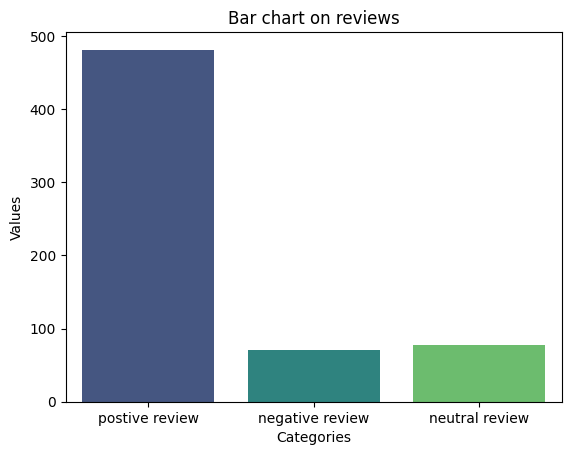

In [23]:
sns.barplot(x=["postive review","negative review","neutral review"],y=[sum(pov_test_ratings),sum(neg_test_ratings),sum(neu_test_ratings)], palette="viridis")
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar chart on reviews')
plt.show()

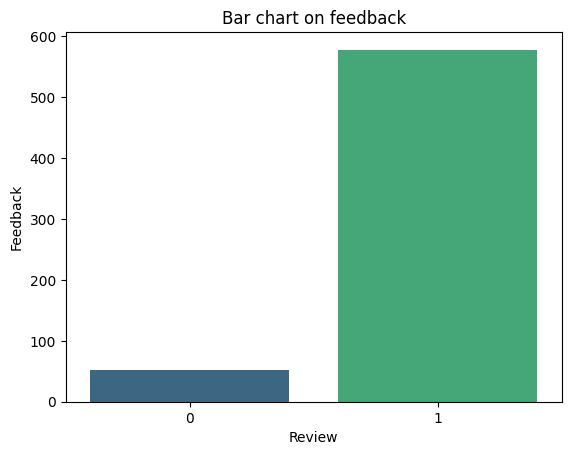

In [24]:
sns.barplot(x=["0","1"],y=[sum([1 for i in test_data['feedback'] if i==0.0]),sum([1 for i in test_data['feedback'] if i==1.0])], palette="viridis")
plt.xlabel('Review')
plt.ylabel('Feedback')
plt.title('Bar chart on feedback')
plt.show()

# ****Downloading the CSV file****

In [25]:
submission=pd.DataFrame({"id":test_data['id'],"sentiment":arr})
submission.to_csv("submission16.csv",index=False)